In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from ml_util import *
from sklearn.model_selection import cross_val_score
from data_loader import DataLoader

cols = ['UpdateTime', 'UpdateMillisec', 'InstrumentID', 'Volume', 'LastPrice', 'OpenInterest', 'PreSettlementPrice',
        'PreClosePrice', 'PreOpenInterest', 'OpenPrice', 'HighestPrice', 'LowestPrice', 'ClosePrice', 'SettlementPrice',
        'UpperLimitPrice', 'LowerLimitPrice', 'BidPrice1', 'AskPrice1', 'BidVolume1', 'AskVolume1', 'Turnover', 'TradingDay', 'LocalTime']

def MACD(mp, window_size):
    ema_long = mp.ewm(span=2*window_size, adjust=False).mean()
    ema_short = mp.ewm(span=window_size, adjust=False).mean()
    diff = ema_long - ema_short
    dea = diff.ewm(span=math.ceil(0.8*window_size), adjust=False).mean()
    return 2*(diff - dea)

contract_size = 300
time_set = [1,3,5,10,20,30,50, 100, 200]
x_col = []
y_col = 'yield_diff'
df_list = []
data_path = '../data/'



In [2]:
# data handling
for f in os.listdir(data_path):
    if 'tick' not in f:
        continue
    df = pd.read_csv(data_path+f, header=0, names = cols, dtype={'UpdateTime':str, 'UpdateMillisec':str})
    df['mp'] = (df['BidPrice1'] + df['AskPrice1'])/2
    df['wp'] = (df['BidPrice1'] * df['BidVolume1'] + df['AskPrice1'] * df['AskVolume1']) / (df['BidVolume1'] + df['AskVolume1'])
    df['rwp'] = (df['BidPrice1'] * df['AskVolume1'] + df['AskPrice1'] * df['BidVolume1']) / (df['BidVolume1'] + df['AskVolume1'])
    df['atp'] = df['Turnover'].diff(1) / df['Volume'].diff(1) / contract_size
    df['wp-mp'] = df['wp'] - df['mp']
    df['rwp-mp'] = df['rwp'] - df['mp']
    df['atp-mp'] = df['atp'] - df['mp']
    df['r10'] = df['mp'].diff(-10) / df['mp']
    df = df[df['UpdateTime'] > '09']
    df['time_str'] = df['UpdateTime'] + df['UpdateMillisec']
    df_x = df[df['InstrumentID'] == 'IF2009']
    df_y = df[df['InstrumentID'] == 'IF2008']
    df = pd.merge(df_x, df_y, on=['time_str'], how='inner')
    df['mid_delta'] = df['mp_x'] - df['mp_y']
    for t in time_set:
        for s in ['x', 'y']:
            df['mid_diff_%s_%d' % (s, t)] = df['mp_%s' % (s)].diff(t)
            x_col.append('mid_diff_%s_%d' % (s, t))
            df['openinterest_diff_%s_%d' % (s, t)] = df['OpenInterest_%s' % (s)].diff(t)
            x_col.append('openinterest_diff_%s_%d' % (s, t))
            df['mid_delta_diff_%d' % (t)] = df['mid_delta'].diff(t)
            x_col.append('mid_delta_diff_%d' % (t))
            df['wp-mp_diff_%s_%d' % (s, t)] = df['wp-mp_%s' %(s)].diff(t)
            x_col.append('wp-mp_diff_%s_%d' % (s, t))
            df['atp-mp_diff_%s_%d' % (s, t)] = df['atp-mp_%s' %(s)].diff(t)
            x_col.append('atp-mp_diff_%s_%d' % (s, t))
            df['rwp-mp_diff_%s_%d' % (s, t)] = df['rwp-mp_%s' %(s)].diff(t)
            x_col.append('rwp-mp_diff_%s_%d' % (s, t))
        if t > 1:
            df['mid_delta_gap_%d'%(t)] = (df['mid_delta'] - df['mid_delta'].rolling(t).mean())/(df['mid_delta'].rolling(t).std()+1e-5)
            x_col.append('mid_delta_gap_%d'%(t))
            df['macd_mid_%s_%d' % (s, t)] = MACD(df['mp_%s'%(s)], t)
            x_col.append('macd_mid_%s_%d' % (s, t))
            
    df_list.append(df)

x_col += ['wp-mp_x', 'atp-mp_x', 'rwp-mp_x']
x_col += ['wp-mp_y', 'atp-mp_y', 'rwp-mp_y']

x_col = list(set(x_col))
    
df = reduce(lambda x,y: x.append(y), df_list)
df[y_col] = df['r10_x'] - df['r10_y']

x, y = df[x_col].values, df[y_col].values

In [ ]:
# ensure no inf
print(np.isinf(df[x_col].describe().loc['max']).sum(), np.isinf(df[x_col].describe().loc['min']).sum())
np.isnan(df[x_col].describe().loc['max']).sum(), np.isnan(df[x_col].describe().loc['min']).sum()

In [ ]:
# scaler
x = RobustScaler().fit_transform(x)
#x_col_map = {t:i for i, t in enumerate(x_col)} 

In [ ]:
# target distribution
plt.title('y distribution')
plt.hist(df[~np.isnan(df[y_col])][y_col])
plt.show()

In [ ]:
# correlation between features and target
PlotFactorCorr(x, y)

In [3]:
# split data into training_set and test_set
test_ratio = 0.2
valid_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

In [ ]:
# linear model
#model = linear_model.ElasticNetCV(alphas=[0.0,0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[0.0, .01, .1, .5, .9, .99, 0.1],  max_iter=5000,  tol=1e-15)
#model.fit(x_train, y_train)
#print('expr:y=%s*x+%lf, iter=%d' % (str(model.coef_), model.intercept_, model.n_iter_))

In [4]:
# xgboost model
model = xgb.XGBClassifier(max_depth=50, learning_rate=0.1, n_estimators=100, silent=False, objective='binary:logistic',
                          booster='gbtree', n_jobs=1, nthread=8, gamma=0, min_child_weight=1, max_delta_step=0,
                          subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
eval_set = [(x_train, y_train>0),(x_valid, y_valid>0)]
model.fit(x_train, y_train>0, eval_set=eval_set, verbose=True, eval_metric=['logloss', 'error'], early_stopping_rounds=5)

y_onehot_pred = model.predict(x_test)
model.get_booster().feature_names = x_col

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


[0]	validation_0-logloss:0.598145	validation_0-error:0	validation_1-logloss:0.598155	validation_1-error:5e-05
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.520355	validation_0-error:0	validation_1-logloss:0.520367	validation_1-error:5e-05
[2]	validation_0-logloss:0.455513	validation_0-error:0	validation_1-logloss:0.455479	validation_1-error:5e-05
[3]	validation_0-logloss:0.400633	validation_0-error:0	validation_1-logloss:0.400662	validation_1-error:5e-05
[4]	validation_0-logloss:0.353761	validation_0-error:0	validation_1-logloss:0.353808	validation_1-error:5e-05
[5]	validation_0-logloss:0.313432	validation_0-error:0	validation_1-logloss:0.313465	validation_1-error:5e-05
Stopping. Best iteration:
[0]	validation_0-logloss:0.598145	validation_0-error:0	validation_1-logloss:0.598155	validation_1-error:5e-05



In [ ]:
import xgboost
isinstance(model, xgboost.sklearn.XGBClassifier)

In [ ]:
ax=plot_importance(model, max_num_features=50)
sf = [yt._text for yt in ax.get_yticklabels()[::-1]]
PlotFactorCorr(df[sf].values, y)

In [ ]:
PlotFactorCorr(df[sf].values, y)

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Confusion matrix, without normalization


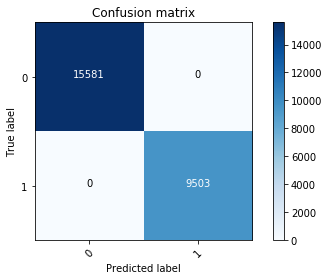

              precision    recall  f1-score   support

      class0       1.00      1.00      1.00     15581
      class1       1.00      1.00      1.00      9503

   micro avg       1.00      1.00      1.00     25084
   macro avg       1.00      1.00      1.00     25084
weighted avg       1.00      1.00      1.00     25084



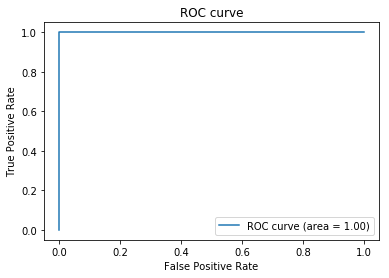

ValueError: invalid literal for int() with base 10: 'ield_diff'

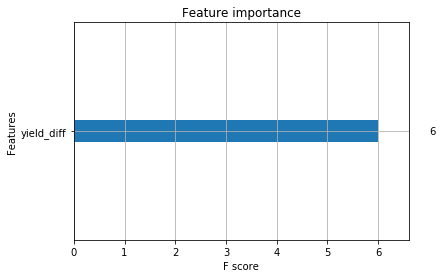

In [5]:
ClsReport(model, y_test>0, y_onehot_pred>0.5, binary=True)
y_onehot_pred

In [ ]:
# xgboost result visualize, and select features according to plot_importance
from ml_util import *
a = ClsReport(model, y_train>0, model.predict(x_train)>0, binary=True, feature_names=x_col)
selected_features = [x_col[i] for i in a if i < len(a) * 0.6]
x = x[:, a]
test_ratio = 0.2
valid_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

In [ ]:
#from sklearn.model_selection import cross_val_score
#a = ClsReport(model, y_test>0, y_pred>0, binary=True)
#model = xgb.XGBClassifier(max_depth=50, learning_rate=0.1, n_estimators=1000, silent=False, objective='binary:logistic', num_classes=2,
                          #booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,
                          #subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
#cross_val_score(model, x, y>0, cv=5)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(np.reshape(y>0, (-1,1)))

In [ ]:
# sample function for lstm
from numpy import random

def GenSeqSamples(x, y, batch_size=64, seq_length=32):
    count = 0
    rx, ry, index = [], [], []
    while count < batch_size:
        i = random.randint(len(x)-seq_length) #, size=batch_size)
        tx, ty = x[i:i+seq_length], y[i+seq_length-1]
        if np.isnan(tx).sum() != 0 or np.isnan(ty).sum() != 0:
            continue
        rx.append(tx)
        #print(ohe.transform(np.reshape(ty>0,(-1, 1))).toarray())
        ry.append(ohe.transform(np.reshape(ty>0,(-1, 1))).toarray()[0])
        index.append(i)
        count += 1
    return np.array(rx), np.array(ry), np.array(index)

In [ ]:
x_train.shape, y_train.shape
xt, yt, _ = GetSamples(x_train, y_train)#, 1, 1)
yt.shape
np.isnan(x_train).sum()
x.shape

In [ ]:
# lstm model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import activations

batch_size = 512
seq_length = 32
def lstm_model():
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_dim = x.shape[1])),#, return_sequences=True))
    #model.add(layers.Flatten())
    #model.add(layers.LSTM(50, input_shape=(seq_length, x.shape[1]),return_sequences=False))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(2, name='out'))
    model.add(layers.Activation('sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-2),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model

model = lstm_model()
model.summary()

#mid_model = Model(inputs=model.input, outputs=model.get_layer('out').output)


In [ ]:
(np.isnan(x_train).sum(axis=1) == 0).shape

In [ ]:
# training
num = batch_size

# filter data: remove those nan and inf
def Filter(x, y):
    nan_cond = (~np.isnan(y)) & (np.isnan(x).sum(axis=1) == 0)
    inf_cond = (~np.isinf(y)) & (np.isinf(x).sum(axis=1) == 0)
    return x[nan_cond & inf_cond], y[nan_cond * inf_cond]
    #print(x.shape, y_shape, rx.shape, ry.shape)

for i in range(20):
    xt ,yt = Filter(x_train, y_train)
    xv, yv = Filter(x_valid, y_valid)
    yt, yv = ohe.transform(np.reshape(yt>0, (-1, 1))), ohe.transform(np.reshape(yv>0, (-1, 1)))
    model.fit(xt, yt, validation_data=[xv, yv])
    #print(GetMidRes(model, 'out', x_input))
    #print(np.isnan(xt).sum())
    #print(model.predict(xt[:num]), GetMidRes(model, 'out', xt[:num]))
    #xt, yt, index = GetSamples(x_train, y_train, batch_size=batch_size, seq_length=seq_length)
    #model.fit(xt[:num, -1, :], yt[:num])
    #print(model.predict(xt[:num]), yt[:num], GetMidRes(model, 'out', xt[:num]))
    #if np.isnan(model.predict(xt[:num])).sum() > 0:
    #print(xt[:num], yt[:num], index, model.predict(xt[:num]))
    #raw_input()
    #break

In [ ]:
for col in x_col:
    df[col].describe()
    df[col].plot.box(title=col)
    plt.show()
    

In [ ]:
from sklearn.preprocessing import StandardScaler as ss
from sklearn.preprocessing import Imputer
df['atp-mp_diff_x_20'].plot.box()
plt.show()
d = np.reshape(df['atp-mp_diff_x_20'].tolist(), (-1, 1))
d = Imputer(missing_values='NaN', strategy='mean',axis=0).fit_transform(d)
plt.boxplot(ss().fit_transform(d))
plt.show()
plt.hist(ss().fit_transform(d))
plt.show()
ss().fit_transform(x)